# Metod potpornih vektora

In [1]:
import os
import cv2
import glob
import fnmatch
import numpy as np
import pandas as pd
import sklearn
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
import imblearn
import seaborn as sns

### Učitavanje podataka

Za učitavanje putanja do slika sa kojima radimo koristimo funkciju ***glob***. Kao argumente prosleđujemo putanje
(sa wild card karakterima koji zamenjuju bilo koje uzastopne karaktere), i parametar *recursive* koji, kada je postavljen
na *True*, omogućava da se pretrga vrši po svim direktorijumima i poddirektorijumima.

In [2]:
imagePatches = glob.glob('C:/Users/pc/Desktop/data/**/*.png', recursive=True)

Koristimo činjenicu da svaka slika u svojoj putanji ima naznačenu klasu kojoj pripada, "class0" za 0, i "class1" za 1.

In [3]:
patternZero = '*class0.png'
patternOne = '*class1.png'

Funkcija ***fnmatch.filter*** pronalazi sve putanje koje u sebi imaju šablon koji prosleđujemo kao drugi argument. Pomoću nje delimo naše putanje u dve grupe, u zavisnosti od klase.

In [4]:
classZero = fnmatch.filter(imagePatches, patternZero) 
classOne = fnmatch.filter(imagePatches, patternOne)

Pravimo funkciju za učitavanje slika. Kao argumente joj prosleđujemo minimalni i maksimalni indeks, kojim iz liste putanja
izdvajamo one sa kojim želimo da radimo. Ovo je korisno zbog veličine skupa podataka, i ograničenih performansi naših računara. Za učitavanje slika koristimo funkciju ***imread*** iz paketa *cv2*. Svakoj slici koju učitamo, funkcijom ***resize*** podešavamo dimenzije, da bismo bili sigurni da su na kraju sve slike istih dimenzija. Parametrom *interpolation* podešavamo način na koji će se na osnovu postojećih piksela dobiti novi.

In [5]:
def load_images(lowerIndex,upperIndex):
    x = []
    y = []
    width = 50
    height = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        image = cv2.imread(img)
        x.append(cv2.resize(image, (width,height), interpolation=cv2.INTER_CUBIC)) # sve slike moraju biti istih dim 
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

Odlučili smo da radimo sa skupom od 40 000 slika.

In [6]:
X,y = load_images(0,40000)

Slike pretvaramo u numpy nizove(matrice).

In [7]:
X = np.array(X)
y = np.array(y)

### Podela podataka na train, validacioni i test skup

In [8]:
X_train_validation,X_test,y_train_validation,y_test = model_selection.train_test_split(X, y, test_size = 0.33, random_state = 42, stratify = y)

In [9]:
print('Broj slika u skupu za treniranje i validaciju:', len(X_train_validation))
print('Broj slika u skupu za testiranje:', len(X_test))

Broj slika u skupu za treniranje i validaciju: 26800
Broj slika u skupu za testiranje: 13200


In [10]:
X_train,X_validation,y_train,y_validation = model_selection.train_test_split(X_train_validation, y_train_validation, test_size = 0.2, random_state = 42, stratify = y_train_validation)

In [11]:
print('Broj slika u skupu za treniranje:', len(X_train))
print('Broj slika u skupu za validaciju:', len(X_validation))

Broj slika u skupu za treniranje: 21440
Broj slika u skupu za validaciju: 5360


### Normalizacija

Slike ćemo proslediti klasifikatoru kao jednodimenzione nizove

In [12]:
X_shape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_train = X_train.reshape(X_train.shape[0], X_shape)
X_validation = X_validation.reshape(X_validation.shape[0],X_shape)
X_test = X_test.reshape(X_test.shape[0],X_shape)

Svodimo vrednosti svakog piksela u opseg [0,1]

In [13]:
X_train = X_train.astype('float32')
X_train = X_train/255

In [14]:
X_validation = X_validation.astype('float32')
X_validation = X_validation/255

In [15]:
X_test = X_test.astype('float32')
X_test = X_test/255

### Nebalansiranost klasa na train skupu

Broj slika koje nemaju tumor:  16484
Broj slika koje imaju tumor:  4956


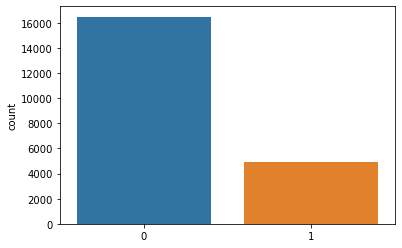

In [16]:
c = np.bincount(y_train)
print('Broj slika koje nemaju tumor: ', c[0])
print('Broj slika koje imaju tumor: ', c[1])
sns.countplot(y_train)
plt.show()

Izbalansiraćemo trening skup metodom undersamplinga. Za ovo koristimo ***RandomUnderSampler***. Parametar *sampling_strategy* postavljen je na vrednst "auto", tako da će nove klase biti iste veličine.

In [17]:
rus = imblearn.under_sampling.RandomUnderSampler(random_state = 0,sampling_strategy = 'auto')
X_train, y_train = rus.fit_sample(X_train, y_train)

In [18]:
print('Broj slika u skupu za treniranje nakon under-samplinga:', len(X_train))

Broj slika u skupu za treniranje nakon under-samplinga: 9912


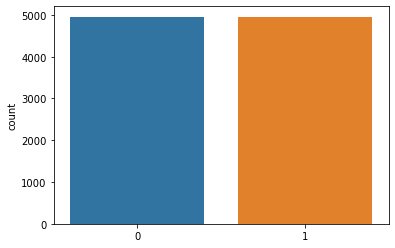

In [19]:
sns.countplot(y_train)
plt.show()

### Redukcija dimenzija pomoću PCA

Pokušaćemo da smanjimo preprilagođavanje redukcijom prostora atributa. Koristićemo Analizu glavnih komponenti(PCA). Detaljniji opis ove metode dat je u prezentaciji.

In [20]:
pca = PCA()
pca.fit(X_train)

PCA()

In [21]:
var = np.cumsum(pca.explained_variance_ratio_)

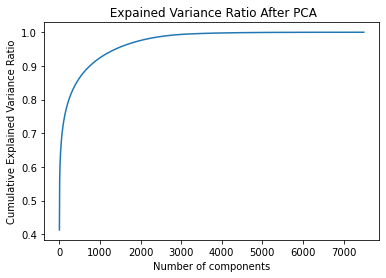

In [22]:
plt.plot(np.arange(X_shape),var)
plt.title(' Expained Variance Ratio After PCA')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

Na grafiku je prikazan udeo objasnjen udeo varijanse u zavisnosti od broja komponenti. Vidimo da je već nakon par stotina komponenti objašnjeno preko 80% varijanse.

In [23]:
X_train.shape

(9912, 7500)

In [24]:
img_pca = PCA(n_components = 0.8)
img_pca.fit(X_train,y_train)
X_train = img_pca.transform(X_train)
X_validation_pca = img_pca.transform(X_validation)

In [25]:
X_train.shape

(9912, 236)

Sveli smo dimenzije podataka sa 7500 na 236.

### Izbor hiperparametara modela

Sledeći korak je izbor parametara modela. Unapred sastavljamo listu potencijalnih vrednosti za svaki od parametara(regularizaciona konstanta i širina kernela). 

In [26]:
Cs = [10**i for i in range(-3,3)]
gammas = [10**i for i in range(-3,3)]
best_c = None
best_gamma = None
best_f1_score = 0

Prolazimo po svim mogućim kombinacijama vrednosti parametara, i ocenjujemo tako dobijene modele na validacionom skupu. Izabraćemo parametre koji daju najbolji model. Kao metriku koristimo F1 skor.

In [27]:
for C in Cs:
    for gamma in gammas:
        model = svm.SVC(kernel = 'rbf', gamma = gamma, C = C)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_validation_pca)
        f1_score = metrics.f1_score(y_validation,y_pred)
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_c = C
            best_gamma = gamma

In [28]:
print("best_f1_score: {:.2f}" .format(best_f1_score))
print("best_c: ", best_c)
print("best_gamma: ", best_gamma)

best_f1_score: 0.68
best_c:  1
best_gamma:  0.01


### Učenje najboljeg modela i evaluacija

Sledi treniranje dobijenog najboljeg modela na uniji trening i validacionog skupa, kako bismo iskoristili što više podataka. Podatke pripremamo na isti način kao kada smo radili samo na trening skupu.

##### Priprema train_validation skupa za treniranje modela

In [29]:
X_train_validation = X_train_validation.reshape(X_train_validation.shape[0],X_shape)

In [30]:
X_train_validation = X_train_validation/255

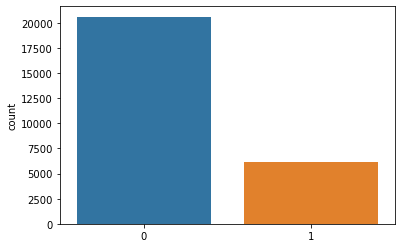

In [31]:
sns.countplot(y_train_validation)
plt.show()

In [32]:
rus = imblearn.under_sampling.RandomUnderSampler(random_state = 0,sampling_strategy = 'auto')
X_train_validation, y_train_validation = rus.fit_sample(X_train_validation, y_train_validation)

In [33]:
img_pca = PCA(n_components = 0.8)
img_pca.fit(X_train_validation,y_train_validation)
X_train_validation = img_pca.transform(X_train_validation)
X_test_pca = img_pca.transform(X_test)

In [34]:
X_train_validation.shape

(12390, 244)

##### Učenje modela i evaluacija

In [35]:
best_model = svm.SVC(kernel = 'rbf', C=best_c, gamma=best_gamma)
best_model.fit(X_train_validation,y_train_validation)

SVC(C=1, gamma=0.01)

Model evaluiramo na test skupu, tako što ga koristimo da predvidimo vrednosti ciljne promenljive za podatke iz test skupa, a zatim poredimo predviđene sa stvarnim vrednostima, koristeći različite metrike.

In [36]:
y_pred = best_model.predict(X_test_pca)

In [37]:
score = metrics.accuracy_score(y_test,y_pred)
print("Tačnost modela: {:.2f}" .format(score))

Tačnost modela: 0.82


In [38]:
f1_score = metrics.f1_score(y_test,y_pred)
print('F1 score modela: {:.2f}' .format(f1_score))

F1 score modela: 0.69


In [39]:
auc_score = metrics.roc_auc_score(y_test,y_pred)
print('auc_score modela: {:.2f}' .format(auc_score))

auc_score modela: 0.83


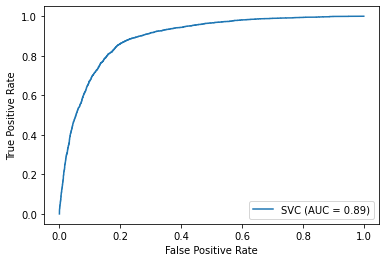

In [40]:
metrics.plot_roc_curve(best_model,X_test_pca,y_test)
plt.show()

In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87     10148
           1       0.58      0.85      0.69      3052

    accuracy                           0.82     13200
   macro avg       0.76      0.83      0.78     13200
weighted avg       0.86      0.82      0.83     13200



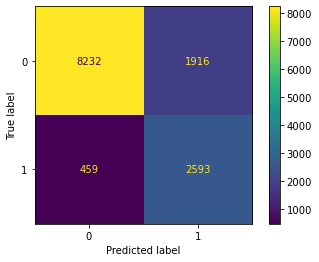

In [42]:
plot_confusion_matrix(best_model,X_test_pca,y_test)
plt.show()

##### Najbolji model treniran na nebalansiranom validacionom skupu

Na kraju ćemo videti kakvi se rezultati dobijaju kada se model trenira na nebalansiranom skupu. Za to cemo iskoristiti validacioni skup, koji u prethodnom postupku dobijanja naboljeg modela nismo balansirali.

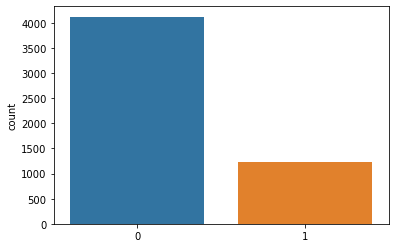

In [43]:
sns.countplot(y_validation)
plt.show()

In [44]:
img_pca = PCA(n_components = 0.8)
img_pca.fit(X_validation,y_validation)
X_validation = img_pca.transform(X_validation)
X_test = img_pca.transform(X_test)

In [45]:
X_validation.shape

(5360, 178)

In [46]:
X_test.shape

(13200, 178)

In [47]:
model = svm.SVC(kernel = 'rbf', C=best_c, gamma=best_gamma)
model.fit(X_validation,y_validation)

SVC(C=1, gamma=0.01)

In [48]:
y_pred1 = model.predict(X_test)

In [49]:
score = metrics.accuracy_score(y_test,y_pred1)
print("Tačnost modela: {:.2f}" .format(score))

Tačnost modela: 0.85


In [50]:
f1_score = metrics.f1_score(y_test,y_pred1)
print('F1 score modela: {:.2f}' .format(f1_score))

F1 score modela: 0.63


In [51]:
auc_score = metrics.roc_auc_score(y_test,y_pred1)
print('auc_score modela: {:.2f}' .format(auc_score))

auc_score modela: 0.75


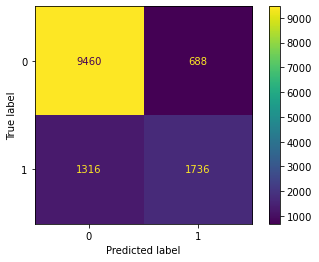

In [52]:
plot_confusion_matrix(model,X_test,y_test)
plt.show()

### Čuvanje modela

In [53]:
import pickle

In [55]:
file_name = 'models/svm.model'
with open(file_name,'wb') as file:
    pickle.dump(best_model,file)